In [1]:
## The usual imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler, BatchSampler

## for printing image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

torch.cuda.is_available()

True

In [3]:
from pathlib import Path
import glob, os
from collections import defaultdict
from sklearn import preprocessing

cwd = Path("C:\\Users\\piyush\\Desktop\\mtp\\expt\\")
dict_for_uts = pd.read_csv(cwd/'dict_for_uts.csv').iloc[:,1:4]
dict_for_uts[:4]

all_files = Path(cwd/"FORCE").glob("*.xls")

rpm_dict, vel_dict = defaultdict(list), defaultdict(list)
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, delimiter="\t")
    df = df.loc[df['X-Pos'] > 5+df['X-Pos'][0]]
    m = df['Z-Load'][:200].mean()
    df = df.loc[df['Z-Load'] > m*(1-0.1)]
    df["Y_Val"]=1
    li.append(df)

for df in li:
    rpm = dict_for_uts.iloc[(dict_for_uts['rpm']-int(round(df.iloc[0:100]["Spindle RPM"].mean(), -2))).abs().argsort()[0]]["rpm"]
    vel = int(round(df.iloc[0:50]['X-Velocity'].mean(), -1))
    uts = dict_for_uts.loc[(dict_for_uts['rpm']==rpm) & (dict_for_uts['ws']==vel)]['UTS (MPa)'].iloc[0]
    df["UTS"] = uts
    rpm_dict[int(rpm)].append(df)
    vel_dict[vel].append(df)

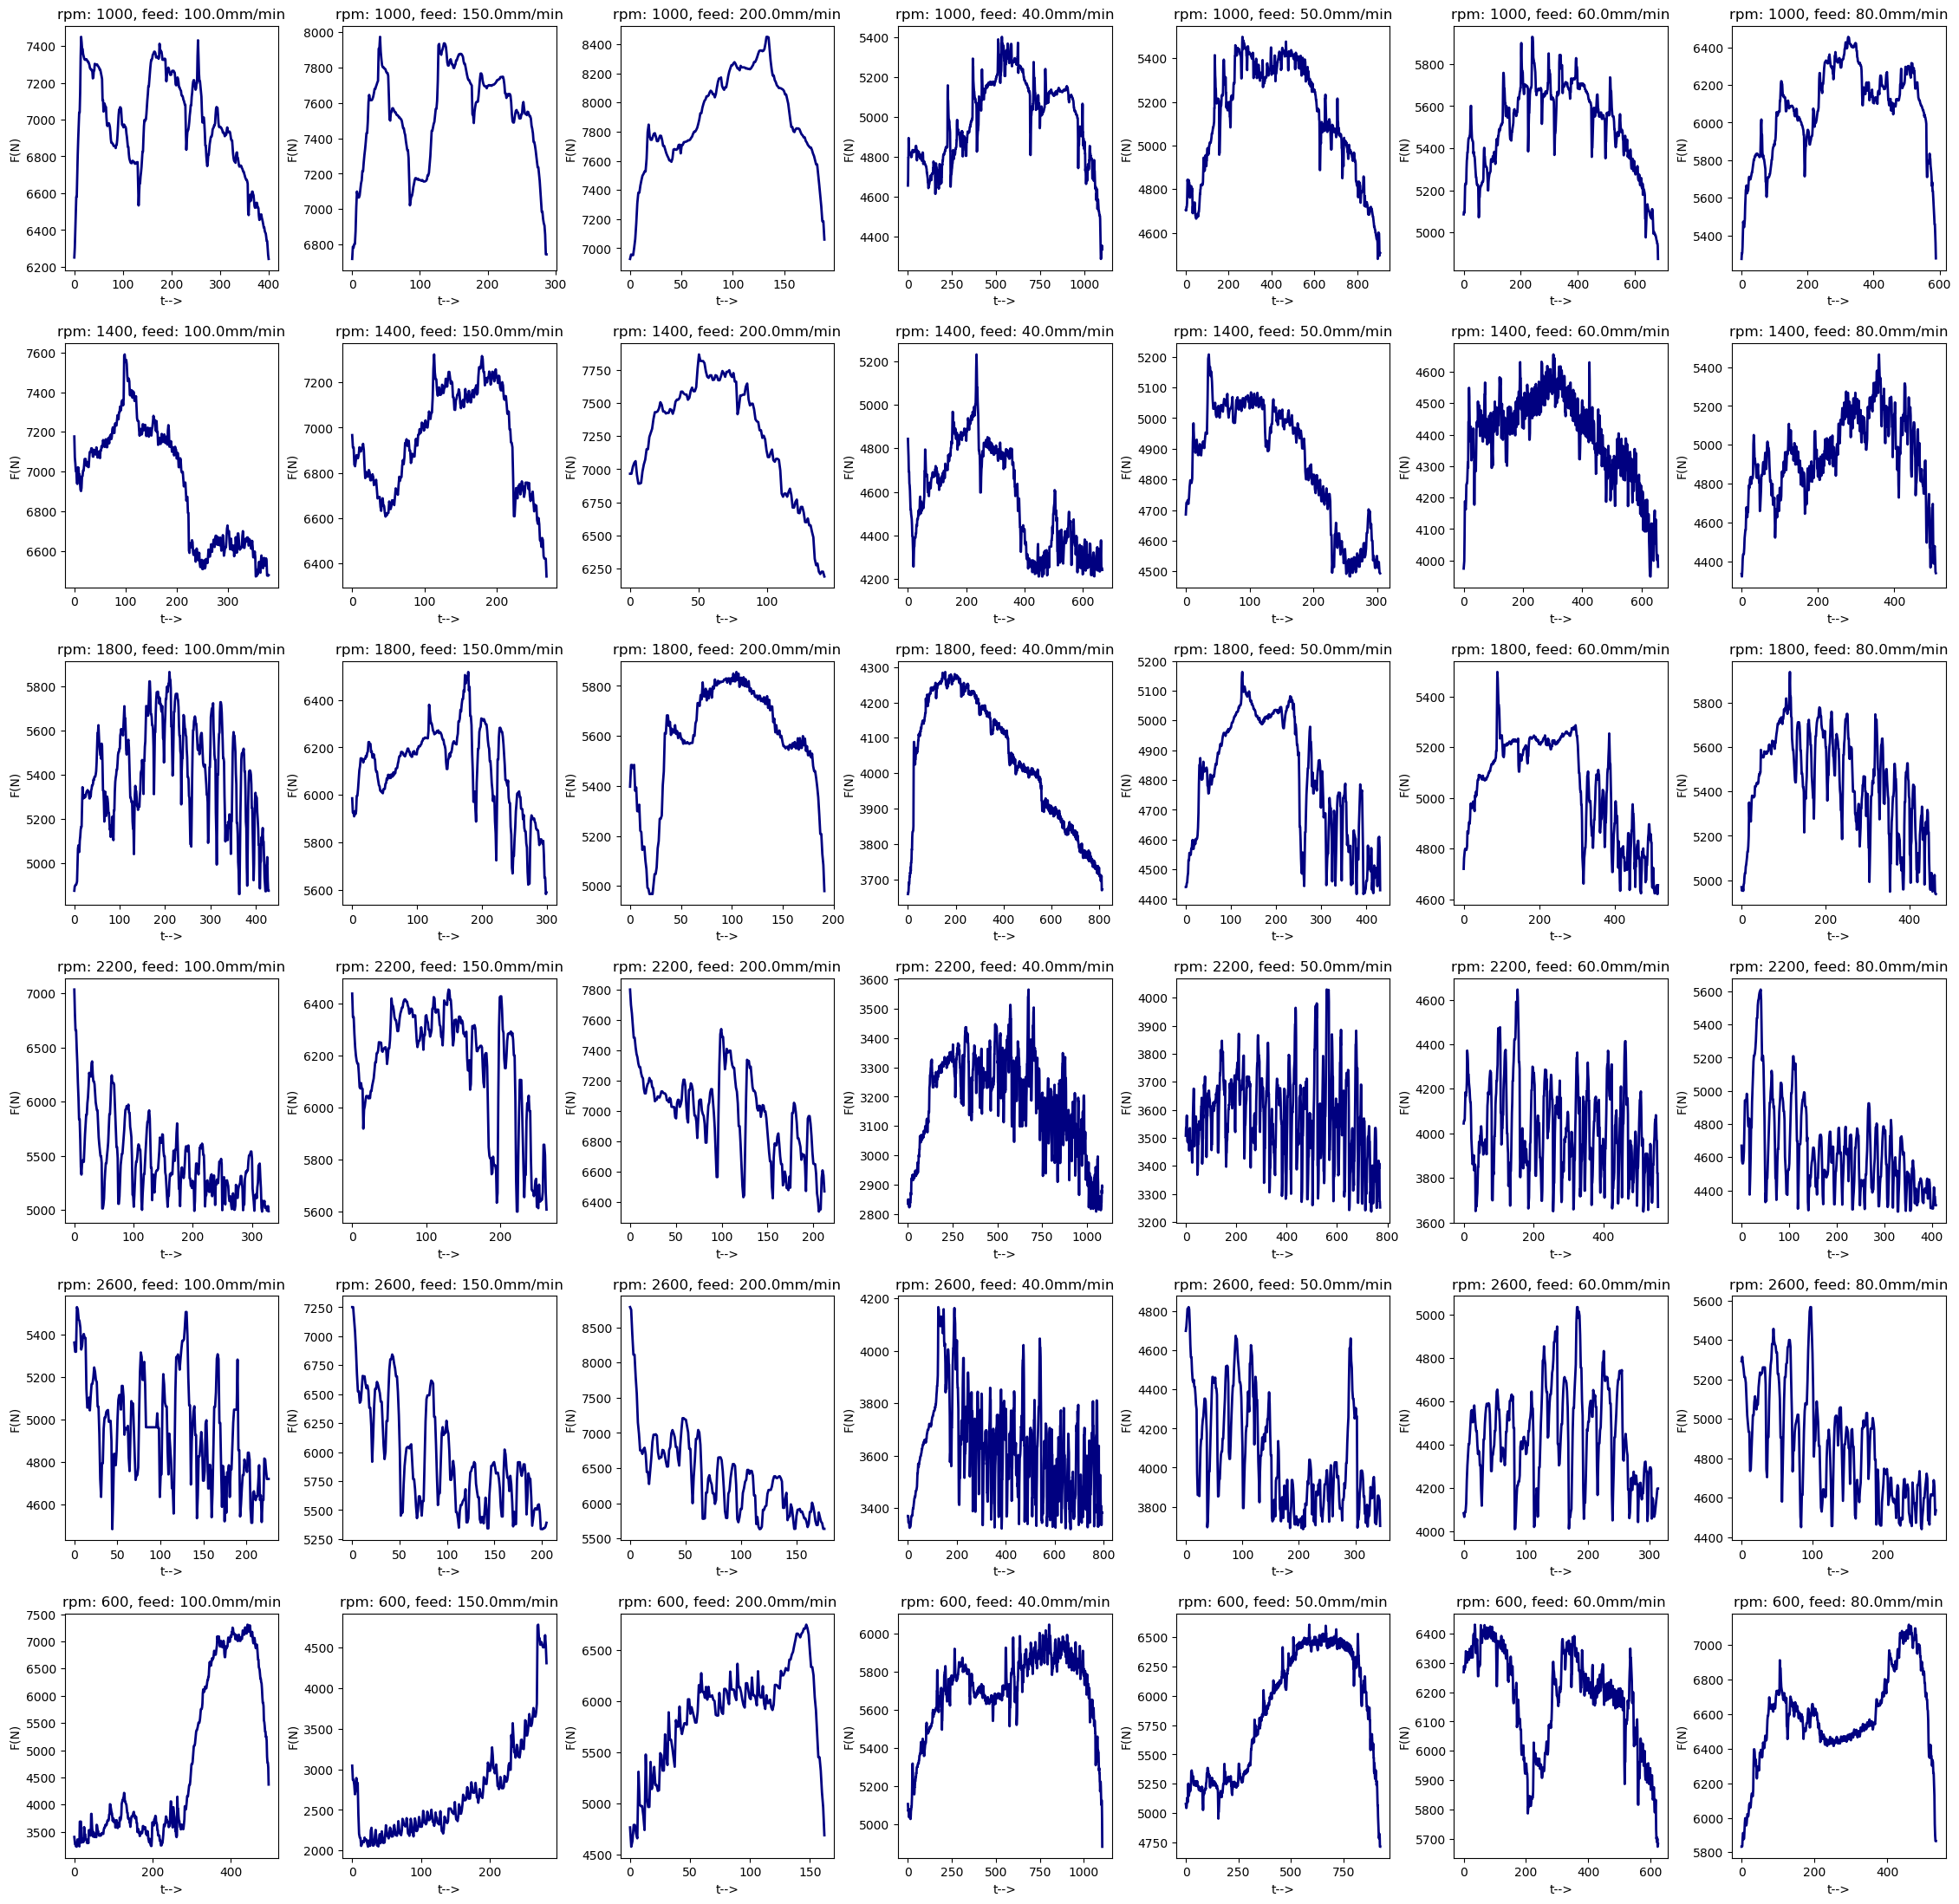

In [6]:
noisy_li = []
ini = 0
fig = plt.figure(figsize=(28, 28), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace = 0.3, wspace=0.3)
for key in rpm_dict:
    for num, df in enumerate(rpm_dict[key]):
#         load_values = df["Z-Load"]
        sigma = np.std(df["Z-Load"])
        
        load = df['Z-Load']
        noisy_load = load + np.random.normal(0,sigma,load.shape)
        
        noisy_li.append(pd.concat([df[["X-Velocity", "Spindle RPM"]],
                        (df['Z-Load'] + np.random.normal(0,sigma,df["Z-Load"].shape)),
                                   df['UTS']], axis=1))
        noisy_li[-1]["Y_Val"] = 0
        
        ax = fig.add_subplot(6,7,ini+num+1)
        
        vel = round(df['X-Velocity'].iloc[:100].mean(), -1)
        ax.set_title("rpm: {}, feed: {}mm/min".format(key, vel))
        ax.set_xlabel("t-->")
        ax.set_ylabel("F(N)")
        line_X = np.linspace(0, df["Z-Load"].shape[0], df["Z-Load"].shape[0])
        
        ax.plot(line_X, load, color='navy', linewidth=2, label='Normal')
#         ax.plot(line_X, noisy_load, color='red', linewidth=1, label='Noisy')
        
        
    ini += num+1
fig.savefig('rpm_plot_force.png')
        

In [4]:
li[0]

,Time (ms),X-Pos,X-Load,X-Torque,X-Velocity,Spindle Torque,Spindle RPM,Z-Load,Z-Position,Weld Temp,Y_Val,UTS
668,66800.0,144.7429,-1.7943,2.700,101.166,14.151,996.9602,6250.8242,81.295,0.0,1,235.4119
669,66900.0,144.9426,-1.7943,3.600,104.313,14.240,991.3322,6304.6538,81.295,0.0,1,235.4119
670,67000.0,145.1427,-1.7943,3.475,100.422,14.151,995.1040,6393.4727,81.295,0.0,1,235.4119
671,67100.0,145.3427,-1.7943,3.250,103.798,14.685,992.9490,6496.3472,81.295,0.0,1,235.4119
672,67200.0,145.5428,-1.7943,3.375,99.220,14.774,996.0704,6580.6812,81.295,0.0,1,235.4119
...,...,...,...,...,...,...,...,...,...,...,...,...
1063,106300.0,210.7102,-1.7943,0.625,105.915,12.816,999.0550,6340.5405,81.300,0.0,1,235.4119
1064,106400.0,210.7102,-1.7943,0.625,105.915,12.816,999.0550,6340.5405,81.300,0.0,1,235.4119
1065,106500.0,210.9101,-1.7943,1.250,99.964,12.193,1000.4016,6301.9624,81.300,0.0,1,235.4119
1066,106600.0,211.1100,-1.7943,1.450,98.820,12.371,999.5542,6264.5806,81.300,0.0,1,235.4119


In [5]:
min(pd.concat(li)['UTS']), max(pd.concat(li)['UTS'])

(146.2, 249.3077)

In [6]:
# Building dataset for Weld data with input as load signals and output as noisy=True(1) or False(0)
class WeldData(Dataset):
    def __init__(self, li, mms, features = ["Z-Load", "Y_Val"]):
        df = pd.concat(li)
        df = df[df.columns & features]
#         print(df)
        x = mms.transform(df.values[:, 0:-1].reshape(-1, 1))
        y = df.values[:, -1]
#         xy = pd.concat(li)[["X-Velocity", "Spindle RPM", "Z-Load", "UTS"]].values
        self.len = y.shape[0]
        self.x_data = torch.from_numpy(x)
        self.y_data = torch.from_numpy(y)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [7]:
class DataLoaderWeld:
    def __init__(self, dataset_size):
        self.dataset_size = dataset_size
        
    def simple_index_generator(self, validation_split=.15, test_split=.15):
        indices = list(range(self.dataset_size))
        split1, split2 = int(np.floor(validation_split * dataset_size)), int(np.floor(test_split * dataset_size))
        
        return (indices[split1+split2:], indices[:split1], indices[split1:split1+split2])
    
    def index_generate(self, k):
        indices = list(range(self.dataset_size))
        split_size = self.dataset_size//k
        test_indices = indices[-split_size:]

        # train_val_set_size
        remain_size = (self.dataset_size-split_size)//k
        for i in range(k):
            yield (indices[:i*remain_size]+indices[(i+1)*remain_size-1:], 
                   indices[i*remain_size:(i+1)*remain_size], 
                   test_indices)
    
    def dataset_prepare(self, dataset, method='k-fold', k=10, bs=32, batch_signal=16): # method is either k-fold or simple
        def loader_prepare(dataset, index_tup):
            train_indices, val_indices, test_indices = index_tup[0], index_tup[1], index_tup[2]
            train_sampler = BatchSampler(SequentialSampler(train_indices), batch_size=batch_signal, drop_last=True)
            valid_sampler =  BatchSampler(SequentialSampler(val_indices), batch_size=batch_signal, drop_last=True)
            test_sampler =  BatchSampler(SequentialSampler(test_indices), batch_size=batch_signal, drop_last=True)

            train_loader = DataLoader(dataset, batch_size=bs, sampler=train_sampler)
            validation_loader = DataLoader(dataset, batch_size=bs, sampler=valid_sampler)
            test_loader = DataLoader(dataset, batch_size=bs, sampler=test_sampler)
            return ({"train": train_loader, "valid": validation_loader, "test": test_loader}, 
                {"train": len(train_indices)//batch_signal+1, 
                 "valid": len(val_indices)//batch_signal+1, 
                 "test": len(test_indices)//batch_signal+1})
        
        dataset_size = len(dataset)
        if method=="simple":
            return loader_prepare(dataset, self.simple_index_generator())
        else:
            for train_indices, val_indices, test_indices in self.index_generate(k):
                data_loaders, data_lengths = loader_prepare(dataset, (train_indices, val_indices, test_indices))
                yield data_loaders, data_lengths

In [15]:
data_loaders, data_lengths = next(g)
n_data_loaders, n_data_lengths = next(noisy_g)

In [17]:
for (data, n_data) in zip(data_loaders['train'], n_data_loaders['train']):
    inputs, labels = data
    n_inputs, n_labels = n_data

    inputs, labels = torch.cat((inputs, n_inputs)), torch.cat((labels, n_labels))
    print(inputs.size())
    rand_seed = torch.randperm(inputs.size()[0])
    inputs, labels = inputs[rand_seed], labels[rand_seed]
    print(*zip(inputs, labels))
#     print(list(labels))
#     print(labels.view(1, -1).tolist())
    break

torch.Size([64, 16, 1])
(tensor([[0.8243],
        [0.8086],
        [0.8318],
        [0.9568],
        [0.8484],
        [0.7985],
        [0.7265],
        [0.8344],
        [0.7539],
        [0.8240],
        [0.8469],
        [0.9010],
        [0.8561],
        [0.8129],
        [0.7945],
        [0.7891]], dtype=torch.float64), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)) (tensor([[0.7811],
        [0.6436],
        [0.6766],
        [0.7419],
        [0.7619],
        [0.6958],
        [0.7149],
        [0.7261],
        [0.6966],
        [0.7295],
        [0.7557],
        [0.7015],
        [0.7320],
        [0.7552],
        [0.7512],
        [0.7200]], dtype=torch.float64), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)) (tensor([[0.7615],
        [0.8450],
        [0.7886],
        [0.7485],
        [0.8099],
        [0.8284],
        [0.7953],
        [0.7692],
   

       dtype=torch.float64)) (tensor([[0.6736],
        [0.6693],
        [0.6648],
        [0.6635],
        [0.6635],
        [0.6669],
        [0.6675],
        [0.6675],
        [0.6651],
        [0.6634],
        [0.6634],
        [0.6571],
        [0.6537],
        [0.6543],
        [0.6556],
        [0.6581]], dtype=torch.float64), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)) (tensor([[0.7394],
        [0.7375],
        [0.6869],
        [0.7144],
        [0.7059],
        [0.7432],
        [0.6350],
        [0.7152],
        [0.6726],
        [0.7399],
        [0.7108],
        [0.6909],
        [0.7486],
        [0.6869],
        [0.7763],
        [0.7057]], dtype=torch.float64), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)) (tensor([[0.7933],
        [0.7291],
        [0.7653],
        [0.7839],
        [0.7391],
        [0.8180],
        [0.7207],
        [0.7163]

       dtype=torch.float64)) (tensor([[0.7508],
        [0.7147],
        [0.8109],
        [0.7003],
        [0.6764],
        [0.7682],
        [0.7081],
        [0.7193],
        [0.7084],
        [0.7212],
        [0.7169],
        [0.7298],
        [0.7400],
        [0.6779],
        [0.6972],
        [0.6744]], dtype=torch.float64), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)) (tensor([[0.8156],
        [0.8139],
        [0.8132],
        [0.8132],
        [0.8125],
        [0.8112],
        [0.8112],
        [0.8102],
        [0.8099],
        [0.8085],
        [0.8055],
        [0.8023],
        [0.8023],
        [0.7987],
        [0.7967],
        [0.7917]], dtype=torch.float64), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)) (tensor([[0.8642],
        [0.8013],
        [0.7558],
        [0.8036],
        [0.7543],
        [0.7325],
        [0.8609],
        [0.7372]

       dtype=torch.float64)) (tensor([[0.6869],
        [0.6861],
        [0.6861],
        [0.6849],
        [0.6828],
        [0.6607],
        [0.6576],
        [0.6689],
        [0.6689],
        [0.6740],
        [0.6689],
        [0.6705],
        [0.6740],
        [0.6765],
        [0.6765],
        [0.6747]], dtype=torch.float64), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)) (tensor([[0.7002],
        [0.7002],
        [0.7003],
        [0.6822],
        [0.6654],
        [0.6752],
        [0.6833],
        [0.6833],
        [0.6887],
        [0.6922],
        [0.6964],
        [0.7025],
        [0.7087],
        [0.7087],
        [0.7202],
        [0.7293]], dtype=torch.float64), tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)) (tensor([[0.7461],
        [0.7528],
        [0.7562],
        [0.7616],
        [0.7649],
        [0.7663],
        [0.7663],
        [0.7635]

In [86]:
class LSTMClassifier(nn.Module):
    def __init__(self, batch_size, input_dim ,hidden_size, output_size=1, gpu=True):
        super(LSTMClassifier, self).__init__()
        self.gpu = gpu
        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.input_dim = input_dim

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_size,
                            num_layers=1,
                            batch_first=True,
                            dropout=0
                           )
        self.label = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
        if(self.gpu): self.cuda()
            
    def init_hidden(self, batch_size=None):
        h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size)).double()
        c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size)).double()
        if self.gpu: h_0, c_0 = h_0.cuda(), c_0.cuda()
        
        return (h_0, c_0)
        
    def forward(self, input_signal):
#         input_signal.size() = (batch_size, num_sequences, 1)
#         batch_size = input_signal.size()[0]
#         input_signal = input_signal.permute(1, 0, 2) # input_signal.size() = (num_sequences, batch_size, 1)
        
        h_0, c_0 = self.init_hidden(batch_size=input_signal.size()[0])
#         nn.utils.rnn.pack_padded_sequence()
        output, (h_n, c_n) = self.lstm(input_signal, (h_0, c_0))
        
#         output = output.contiguous()
#         output = output.view(-1, output.shape[2])
#         print(output[:,-1,:].size())
        print(output.size())
        final_output = self.label(output[:,-1,:]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)

#         print(final_output.size())
        
        final_output = self.sigmoid(final_output)
        
        return final_output
    
    

In [87]:
bs = 32
hidden_size = 200
batch_signal = 16
input_dim = 1
model = LSTMClassifier(batch_size=64, input_dim=input_dim, hidden_size=hidden_size, output_size=1, gpu=False).double()

# criterion = torch.nn.BCELoss()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)

n_epochs = 500
k_fold_size = 10


In [88]:
mms = preprocessing.MinMaxScaler(feature_range=(0, 1))
mms.fit(pd.concat(li)["Z-Load"].values.reshape(-1, 1))

noisy_dataset = WeldData(noisy_li, mms)
noisy_loader = DataLoaderWeld(len(noisy_dataset))

dataset = WeldData(li, mms)
loader = DataLoaderWeld(len(dataset))


noisy_g = noisy_loader.dataset_prepare(noisy_dataset, method='k-fold', k=k_fold_size, bs=bs, batch_signal=batch_signal)
g = loader.dataset_prepare(dataset, method='k-fold', k=k_fold_size, bs=bs, batch_signal=batch_signal)

In [89]:
model.state_dict

<bound method Module.state_dict of LSTMClassifier(
  (lstm): LSTM(1, 200, batch_first=True)
  (label): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)>

In [90]:
# Training loop
# generator = loader.dataset_prepare(dataset, method='k-fold', k=k_fold_size, bs=32, batch_signal=batch_signal)
data_loaders, data_lengths = next(g)
n_data_loaders, n_data_lengths = next(noisy_g)
for epoch in range(n_epochs):
    
    if(epoch and epoch%10==0):
        if(epoch%(10*(k_fold_size))==0):
            noisy_g = noisy_loader.dataset_prepare(noisy_dataset, method='k-fold', k=k_fold_size, bs=32, batch_signal=batch_signal)
            g = loader.dataset_prepare(dataset, method='k-fold', k=k_fold_size, bs=32, batch_signal=batch_signal)
            
        print("\nChanging the X-Validation set\n")
        data_loaders, data_lengths = next(g)
        n_data_loaders, n_data_lengths = next(noisy_g)
        
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)
    for phase in ['train', 'valid']:
        if phase == 'train':
#             scheduler.step()
            model.train(True)  # Set model to training mode
        else:
            model.train(False)

        running_loss = 0.0
        for (data, n_data) in zip(data_loaders[phase], n_data_loaders[phase]):
#             if(data[1].size()[0]<32):
#                 continue
            
            # get the inputs
            inputs, labels = data
            n_inputs, n_labels = n_data
            
            inputs, labels = torch.cat((inputs, n_inputs)), torch.cat((labels, n_labels))
            rand_seed = torch.randperm(inputs.size()[0])
            inputs, labels = inputs[rand_seed], labels[rand_seed]
            
            inputs, labels = Variable(inputs), labels[:, 0]
            
            y_pred = model(inputs)

            labels = labels.view(-1, 1)
            
#             labels_ohe = torch.FloatTensor(labels.size()[0], 2)
#             labels_ohe.zero_().scatter_(1, labels, 1)
            
#             print(labels_ohe)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()
                
            running_loss += loss.item()
        epoch_loss = running_loss * bs * 2/ (data_lengths[phase]+n_data_lengths[phase])
        print("{} Loss: {:.6f}".format(phase, epoch_loss))
    scheduler.step(epoch_loss)
    if(epoch%5==0):
        torch.save(model.state_dict(), cwd/'saved_models'/'model_{}.pth'.format(epoch))
    

Epoch 0/499
----------
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([64, 16, 200])
torch.Size([6, 16, 200])
train Loss: 0.71

KeyboardInterrupt: 

In [164]:
test_model = LSTMClassifier(batch_size=64, input_dim=16, hidden_size=200, gpu=False).double()
test_model.load_state_dict(torch.load(cwd/'saved_models'/'model_50.pth'))
test_model.eval()

# den = 249.3077-146.2
running_error = 0.0 
with torch.no_grad():
    for (data, n_data) in zip(data_loaders['test'], n_data_loaders['test']):
        inputs, labels = data
        labels = labels.view(-1, 1)
        n_inputs, n_labels = n_data
        n_labels = n_labels.view(-1, 1)
        
#         inputs, labels = inputs.double(), labels.double()
        
        inputs, labels = torch.cat((inputs, n_inputs)).double(), torch.cat((labels, n_labels)).double()
        y_pred = test_model(inputs)
        print(y_pred, labels)
        y_pred = [int(x[0]>0.5) for x in y_pred]
        
        labels = np.array(labels.view(-1))
        print(y_pred, labels)
        print(sum(np.abs(y_pred-labels)))
        break
        
        abs_error = np.abs(y_pred-labels)
        running_error += sum(abs_error)

print(running_error)
# epoch_loss = running_error / data_lengths['test']

# with torch.no_grad():


tensor([[0.0875, 0.0852],
        [0.0874, 0.0851],
        [0.0874, 0.0851],
        [0.0879, 0.0857],
        [0.0885, 0.0863],
        [0.0881, 0.0858],
        [0.0885, 0.0863],
        [0.0888, 0.0866],
        [0.0886, 0.0863],
        [0.0874, 0.0852],
        [0.0872, 0.0850],
        [0.0875, 0.0852],
        [0.0875, 0.0853],
        [0.0878, 0.0856],
        [0.0881, 0.0859],
        [0.0874, 0.0851],
        [0.0885, 0.0863],
        [0.0883, 0.0861],
        [0.0883, 0.0861],
        [0.0884, 0.0861],
        [0.0887, 0.0865],
        [0.0890, 0.0868],
        [0.0893, 0.0871],
        [0.0896, 0.0874],
        [0.0901, 0.0880],
        [0.0878, 0.0855],
        [0.0866, 0.0843],
        [0.0861, 0.0837],
        [0.0867, 0.0844],
        [0.0871, 0.0848],
        [0.0878, 0.0855],
        [0.0877, 0.0855],
        [0.0875, 0.0852],
        [0.0872, 0.0849],
        [0.0873, 0.0850],
        [0.0880, 0.0858],
        [0.0884, 0.0861],
        [0.0885, 0.0863],
        [0.0

ValueError: operands could not be broadcast together with shapes (64,) (1024,) 

In [128]:
# 1.4376 % error without X-validation
# # 1.5984 % error without X-validation
epoch_loss*100

tensor(1.4376)

In [129]:
mms = preprocessing.MinMaxScaler(feature_range=(0, 1))
mms.fit(pd.concat(li)[["X-Velocity", "Spindle RPM", "Z-Load", "UTS"]].values)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [153]:
# Mean of a particular batch of signal values
def mean_generator(arr, bs=32):
    ans = []
    for i in range(0, len(arr), bs):
        ans.append(np.mean(arr[i:i+bs+1]))
    return ans

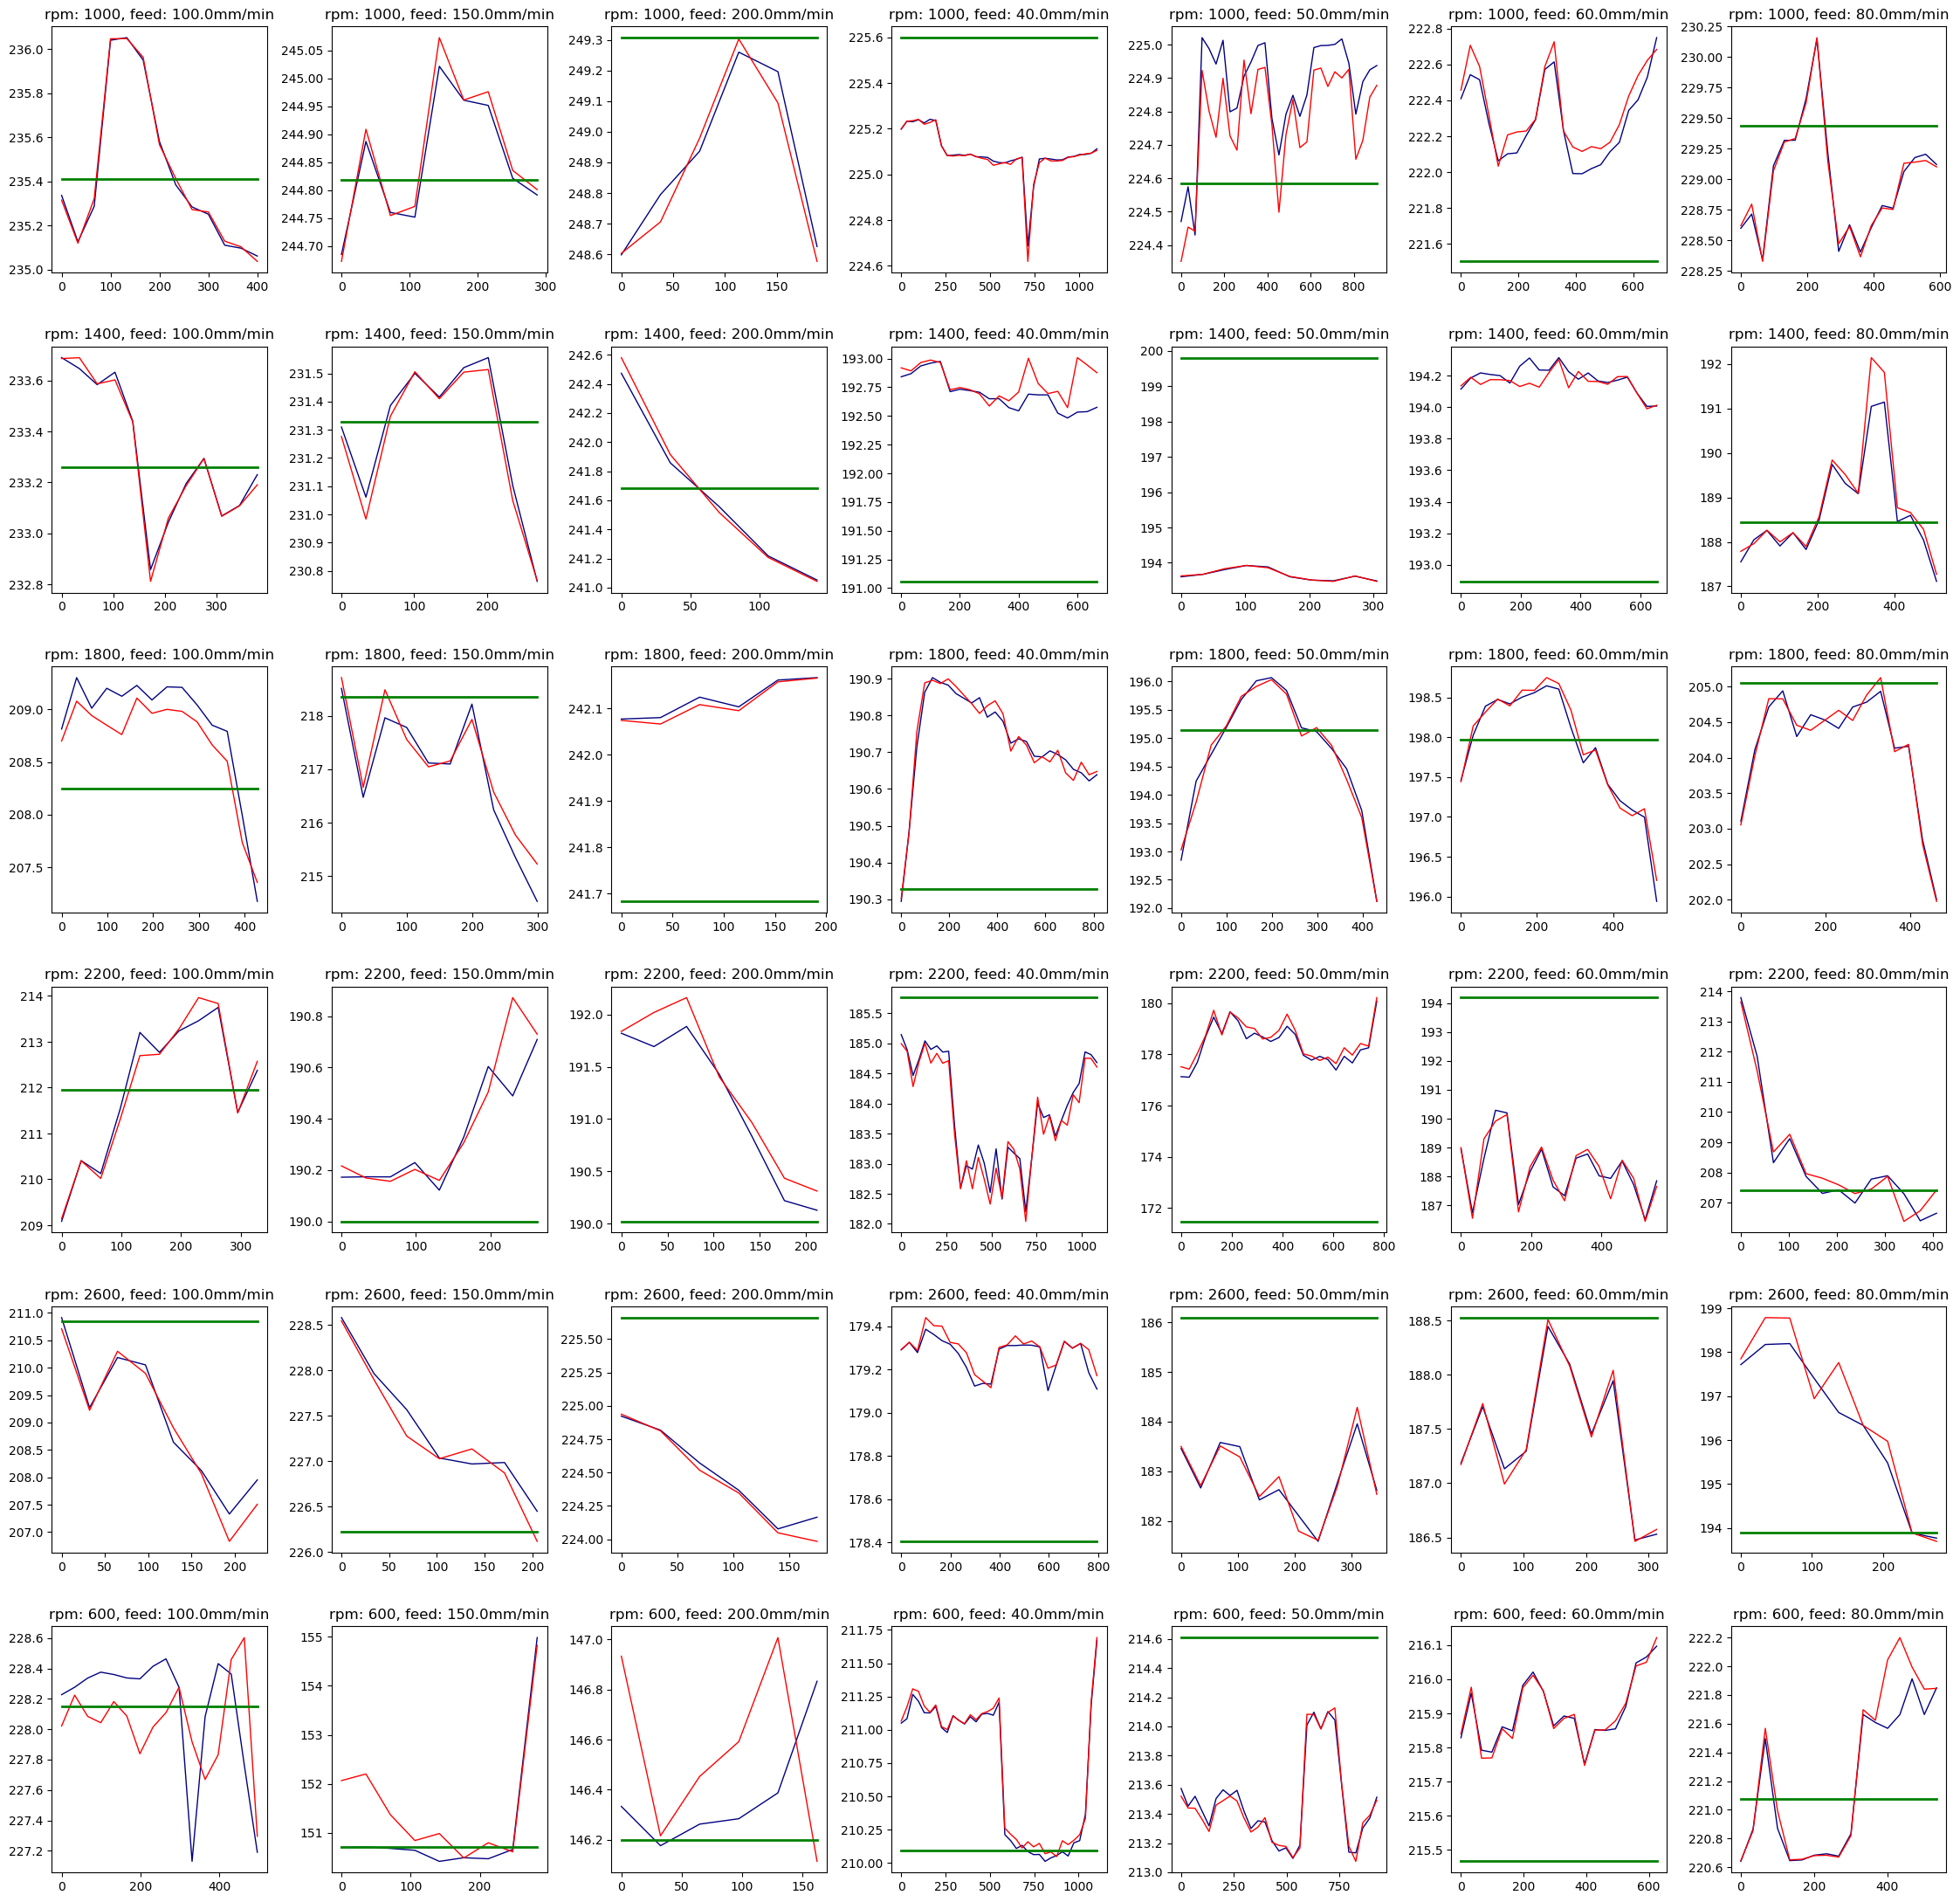

In [159]:
fig = plt.figure(figsize=(28, 28), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace = 0.3, wspace=0.3)
with torch.no_grad():
    ini = 0
    for key in rpm_dict:
        for num, plot_df in enumerate(rpm_dict[key]):
            ax = fig.add_subplot(6,7,ini+num+1)
            line_X = np.linspace(0, plot_df["Z-Load"].shape[0], plot_df["Z-Load"].shape[0]//bs+1)
            features = mms.transform(plot_df[["X-Velocity", "Spindle RPM", "Z-Load", "UTS"]].values)
            
            load_values = features[:, 2]
            sigma = np.std(load_values)
            line_Y_uts = features[:, -1]
            line_Y_uts = mms.inverse_transform(np.column_stack((features[:, :-1], line_Y_uts)))[:, -1]
            line_Y_uts = mean_generator(line_Y_uts, bs)
            
            line_Y = np.squeeze(test_model(torch.from_numpy(features[:, :-1]).float())).numpy()
            line_Y = mms.inverse_transform(np.column_stack((features[:, :-1], line_Y)))[:, -1]
            line_Y = mean_generator(line_Y, bs)
            
            noisy_values = load_values + np.random.normal(0,sigma,plot_df["Z-Load"].shape)
            line_Y_noise = np.squeeze(test_model(torch.from_numpy(np.column_stack((features[:, :-2], noisy_values))).float())).numpy()
#             print(features[:, :-2].shape, noisy_values.shape)
            line_Y_noise = mms.inverse_transform(np.column_stack((features[:, :-1], line_Y_noise)))[:, -1]
            line_Y_noise = mean_generator(line_Y_noise, bs)
    
            vel = round(plot_df['X-Velocity'].iloc[:100].mean(), -1)

            ax.plot(line_X, line_Y, color='navy', linewidth=1, label='Normal')
            ax.plot(line_X, line_Y_noise, color='red', linewidth=1, label='Noisy')
            ax.plot(line_X, line_Y_uts, color='green', linewidth=2, label='UTS')
            ax.set_title("rpm: {}, feed: {}mm/min".format(key, vel))

#             ts, k1, k2, s1, s2 = tstd(line_Y_noise), kurtosis(line_Y), kurtosis(line_Y_noise), skew(line_Y), skew(line_Y_noise)
#             row_list.append([key, round(plot_df.iloc[0:10]['X-Velocity'].mean(), -1), "O: {:0.2f}, N: {:0.2f}".format(sigma, ts), 
#                            "O: {:0.2f}, N: {:0.2f}".format(s1, s2), "O: {:0.2f}, N: {:0.2f}".format(k1, k2)])
#             rpm_review[key].append({'vel': vel, 'std_o': sigma, 'std_n': ts, 'skew_o': s1, 'skew_n': s2, 'kurt_o': k1, 'kurt_n': k2})
        ini += num+1
